In [ ]:
# Import Necessary Libiraries
import os
import numpy as np
import shutil
import glob
import random
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing

In [ ]:
'''data_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])'''

data_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
train_dir = 'drive/My Drive/PaymentReceipt/dataset/train'
test_dir = 'drive/My Drive/PaymentReceipt/dataset/test'
val_dir = 'drive/My Drive/PaymentReceipt/dataset/val'

# Dataset for training and evaluation
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=data_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transform)

# batch size
mini_batch_size = 16

# Load Data
train_loader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=mini_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=mini_batch_size, shuffle=False)

class_names = ('AYAPay', 'CBPay', 'KPay', 'Other', 'WavePay')

## Modeling

In [ ]:
import torchvision.models as models
import torch.nn as nn

# model
model_rn = models.resnet18(pretrained=True)
print (model_rn)

# Fine-Tuning
for param in model_rn.parameters():
    param.requires_grad = False

model_rn.fc = nn.Linear(model_rn.fc.in_features, len(class_names), bias=False)

# Fine-Tuning
for param in model_rn.fc.parameters():
    param.requires_grad = True

print(model_rn)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def check_gpu():

  use_gpu = torch.cuda.is_available()
  unit = "cpu"

  if use_gpu:
    print ("-------GPU Mode--------")
    unit = "cuda"

  else:
    print ("-------CPU Mode--------")

  device = torch.device(unit)

  return device

In [ ]:
base_path = 'drive/My Drive/'
model_path = os.path.join(base_path, 'PaymentReceipt', 'model','ResNet18')
os.makedirs(model_path, exist_ok= True)

In [ ]:
def train_model(model, dataset_loader, optimizer, device):

    model.train()

    loss_summary = 0
    correct = 0

    train_num = len(dataset_loader.dataset)

    for data, target in dataset_loader:

        input_datas, labels = data.to(device), target.to(device)

        optimizer.zero_grad()

        predicted = model(input_datas)

        loss = criterion(predicted, labels)
        loss_summary += loss.item()

        loss.backward()

        optimizer.step()

        pred_labels = torch.max(predicted, 1)[1]
        correct += (pred_labels == labels).sum().item()

    average_loss = loss_summary / train_num
    accuracy = correct / train_num

    return model, average_loss, accuracy

def eval_model(model, dataset_loader, device):

  model.eval()

  loss_summary = 0
  correct = 0
  test_num = len(dataset_loader.dataset)

  with torch.no_grad():
    for data, target in dataset_loader:

      input_datas, labels = data.to(device), target.to(device)

      predicted = model(input_datas)

      loss = criterion(predicted, labels)
      loss_summary += loss.item()

      pred_labels = torch.max(predicted, 1)
      correct += (pred_labels[1] == labels).sum().item()

  average_loss = loss_summary / test_num
  accuracy = correct / test_num

  return average_loss, accuracy

def plot_graph(train, val, label):

    plt.plot(train, label='train')
    plt.plot(val, label='validation')
    plt.ylabel(label)
    plt.xlabel("Epoch")
    plt.legend()
    plt.savefig(os.path.join(model_path,label + '_Model_Accuracy_ResNet18.png'), dpi=300, bbox_inches='tight')
    plt.show()

def save_model_checkpoint(model, acc, max_acc, epoch, path):

    if acc > max_acc:
        torch.save(model.state_dict(), path.format(epoch))
        return acc

    else:
        return max_acc

def training(model, epoch_num, path, optimizer):

    max_acc = 0
    max_epoch_size = epoch_num

    train_losses = []
    train_acc = []
    val_losses = []
    val_acc = []

    # Check GPU
    device = check_gpu()
    model = model.to(device)

    print("Start Training!")
    for epoch in range(max_epoch_size):
        print('Epoch: {}'.format(epoch))

        # training
        model, loss, acc = train_model(model, train_loader, optimizer, device)
        train_losses.append(loss)
        train_acc.append(acc)
        print("Train loss: {} acc: {}".format(loss, acc))

        # Evaluation while training
        loss, acc = eval_model(model, val_loader, device)
        val_losses.append(loss)
        val_acc.append(acc)
        print("Val loss: {} acc: {}\n\n".format(loss, acc))

        # Save the model when accuracy improves.
        max_acc = save_model_checkpoint(model, acc, max_acc, epoch, path)

    print("finish Training")
    print('Max Accuracy {}'.format(max_acc))

    # plot for loss
    plot_graph(train_losses, val_losses, 'Loss')
    # plot for accuracy
    plot_graph(train_acc, val_acc, 'Accuracy')

-------GPU Mode--------
Start Training!
Epoch: 0
Train loss: 0.0727049211661021 acc: 0.5891472868217055
Val loss: 0.04182447667451615 acc: 0.8297872340425532


Epoch: 1
Train loss: 0.03566992932627367 acc: 0.8430232558139535
Val loss: 0.0320734589340839 acc: 0.8404255319148937


Epoch: 2
Train loss: 0.029190880759048833 acc: 0.874031007751938
Val loss: 0.02263781325297153 acc: 0.9148936170212766


Epoch: 3
Train loss: 0.02397348289919454 acc: 0.8914728682170543
Val loss: 0.018765381676085453 acc: 0.9042553191489362


Epoch: 4
Train loss: 0.020512777272351953 acc: 0.9205426356589147
Val loss: 0.018079204881127846 acc: 0.9042553191489362


Epoch: 5
Train loss: 0.017890498446401698 acc: 0.9321705426356589
Val loss: 0.01519570158834153 acc: 0.925531914893617


Epoch: 6
Train loss: 0.018694681295937345 acc: 0.939922480620155
Val loss: 0.01442267175050492 acc: 0.925531914893617


Epoch: 7
Train loss: 0.015144829270105029 acc: 0.9476744186046512
Val loss: 0.012787242083156363 acc: 0.925531914

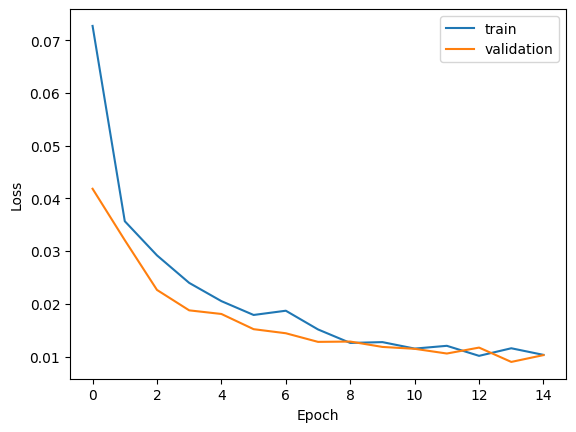

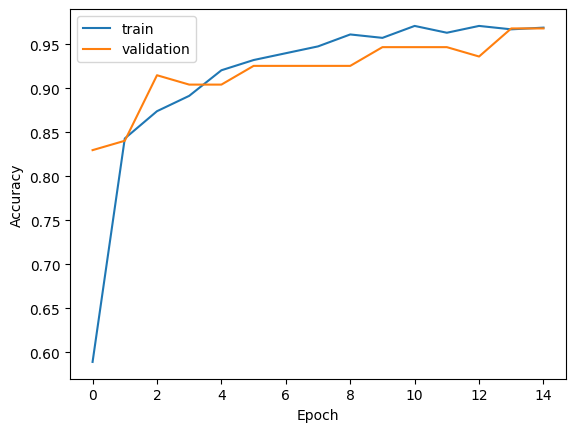

In [ ]:
epoch = 15
file_output_path = model_path + '/resnet18_{:02}.pth'
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_rn.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.1)

# Starting model
training(model_rn, epoch, file_output_path, optimizer)

## Evaluation

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, y_true, y_pred, classes, plot_label):

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix(' + plot_label + ')')
    plt.savefig(os.path.join(model_path,plot_label + '_confusion_matrix_resnet18.png'), dpi=300, bbox_inches='tight')
    plt.show()

def plot_classification_report(y_true, y_pred, class_names, plot_label):
    print (classification_report(y_true ,y_pred))
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    # Convert the report into a DataFrame for easier plotting
    report_df = pd.DataFrame(report).transpose()

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:, :3], annot=True, fmt=".2f", cmap="Blues")
    plt.title('Classification Report(' + plot_label + ')')
    plt.xlabel("Metrics")
    plt.ylabel("Classes")
    plt.savefig(os.path.join(model_path, plot_label +'_Classification_Reportx_resnet18.png'), dpi=300, bbox_inches='tight')
    plt.show()

def clf_report(target ,pred , plot_label):
    cm = confusion_matrix(target, pred)
    plot_confusion_matrix(cm,target, pred, class_names, plot_label)
    plot_classification_report(target ,pred, class_names, plot_label)

def detail_eval(model, dataset_loader, plot_label):

  device = check_gpu()
  model = model.to(device)

  model.eval()

  teach_labels_array = []
  pred_labels_array = []

  with torch.no_grad():
    for data, target in dataset_loader:

      input_datas, labels = data.to(device), target.to(device)

      predicted = model(input_datas)
      probabilities = F.softmax(predicted, dim=1)
      predicted_class_index = torch.max(probabilities, dim=1)[1]

      pred_labels = torch.max(predicted, 1)

      teach_labels_array.extend(labels.cpu().numpy())
      pred_labels_array.extend(pred_labels[1].cpu().numpy())

  # Confusion-Matrix & Classification_report
  clf_report(teach_labels_array, pred_labels_array, plot_label)

<ipython-input-10-2d8fc821d4e6>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_rn.load_state_dict(torch.load(load_path))


-------GPU Mode--------


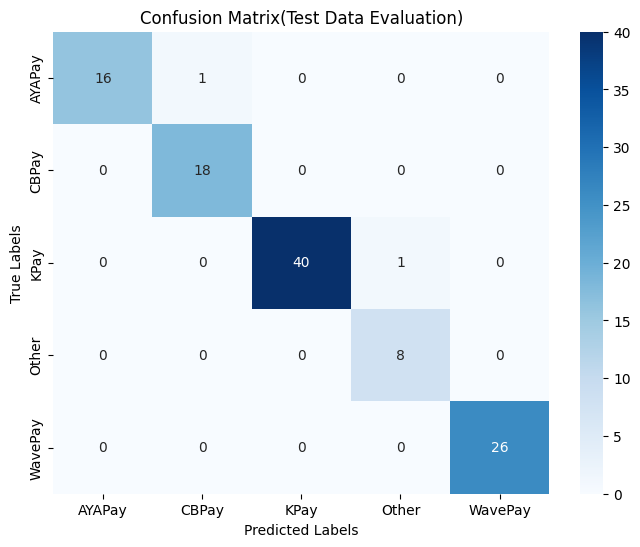

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.95      1.00      0.97        18
           2       1.00      0.98      0.99        41
           3       0.89      1.00      0.94         8
           4       1.00      1.00      1.00        26

    accuracy                           0.98       110
   macro avg       0.97      0.98      0.97       110
weighted avg       0.98      0.98      0.98       110



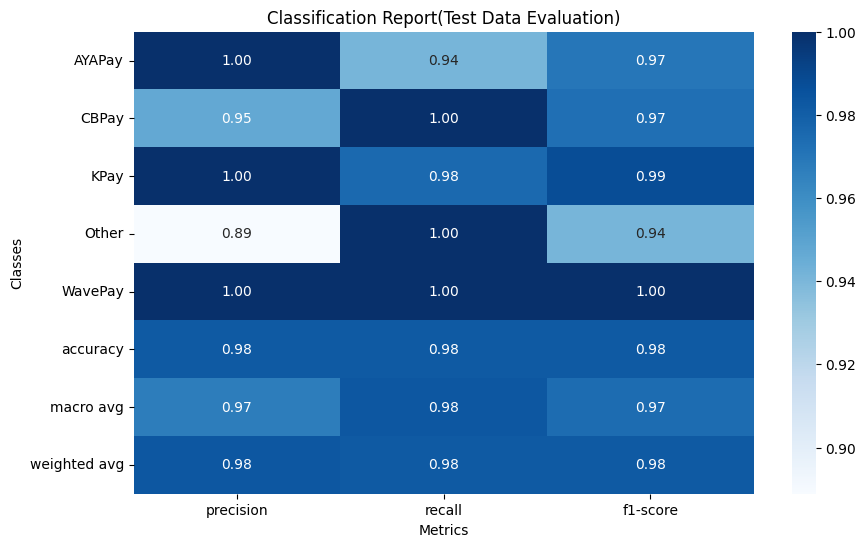

-------GPU Mode--------


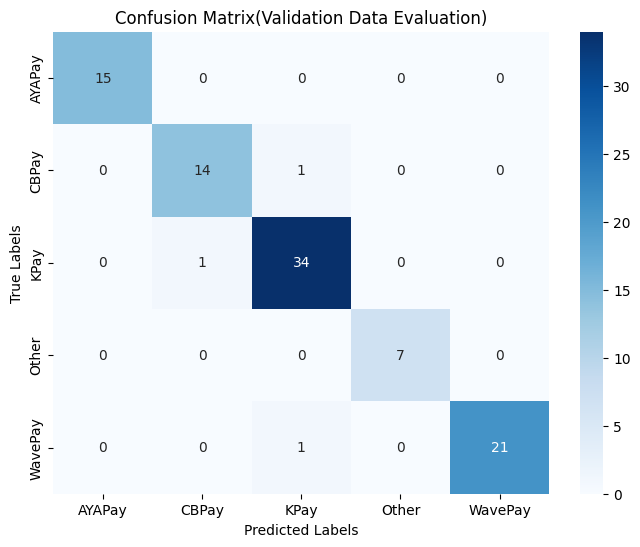

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.93      0.93      0.93        15
           2       0.94      0.97      0.96        35
           3       1.00      1.00      1.00         7
           4       1.00      0.95      0.98        22

    accuracy                           0.97        94
   macro avg       0.98      0.97      0.97        94
weighted avg       0.97      0.97      0.97        94



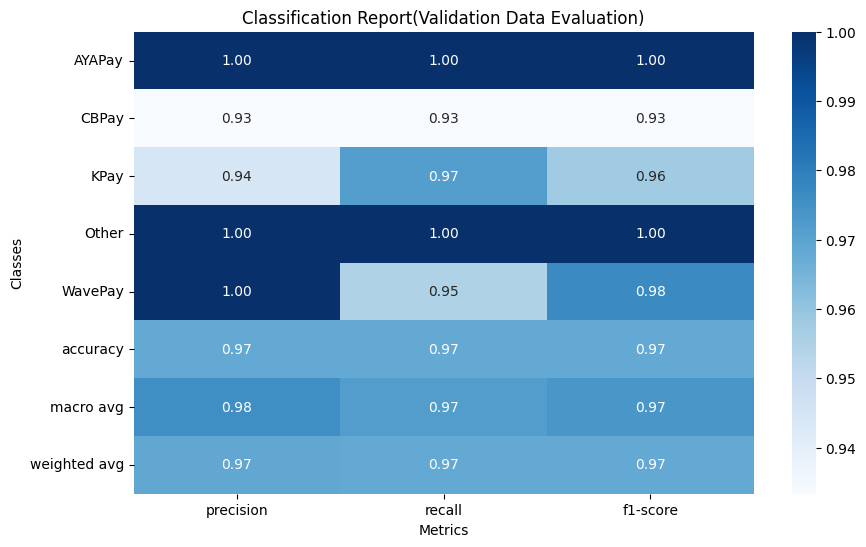

In [ ]:
import torchvision.models as models
import torch.nn as nn

load_path = model_path + '/resnet18_13.pth'

model_rn.load_state_dict(torch.load(load_path))

detail_eval(model_rn, test_loader, 'Test Data Evaluation')
detail_eval(model_rn, val_loader, 'Validation Data Evaluation')